<a href="https://colab.research.google.com/github/Shukaria10/Potato_final_year_project/blob/main/Potato_VGG16_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 46kB/s 


In [ ]:
!nvidia-smi

Sun May  9 02:09:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import libraries**

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.applications import vgg16
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

# **Data augmentation,Train,Test,Validation**

In [4]:
from keras_preprocessing.image import ImageDataGenerator

data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    validation_split=0.3)

In [5]:
img_shape=300
batch_size=16

In [6]:
#load the training data
leaves_train_generator = data_gen.flow_from_directory(
    '/content/drive/MyDrive/final_year_project/dataset_splits/train',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 1205 images belonging to 3 classes.


In [7]:
#load the training data
val_suffle=False
leaves_val_generator = data_gen.flow_from_directory(
    '/content/drive/MyDrive/final_year_project/dataset_splits/validation',
    target_size=(img_shape,img_shape),
    batch_size=16,
    class_mode='categorical',
    subset='validation',shuffle=val_suffle)#shuffle should be False in validation
    #https://stackoverflow.com/a/47439789/11170350

Found 96 images belonging to 3 classes.


In [8]:
leaves_train_generator.next()[0].shape,leaves_train_generator.next()[1].shape

((16, 300, 300, 3), (16, 3))

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

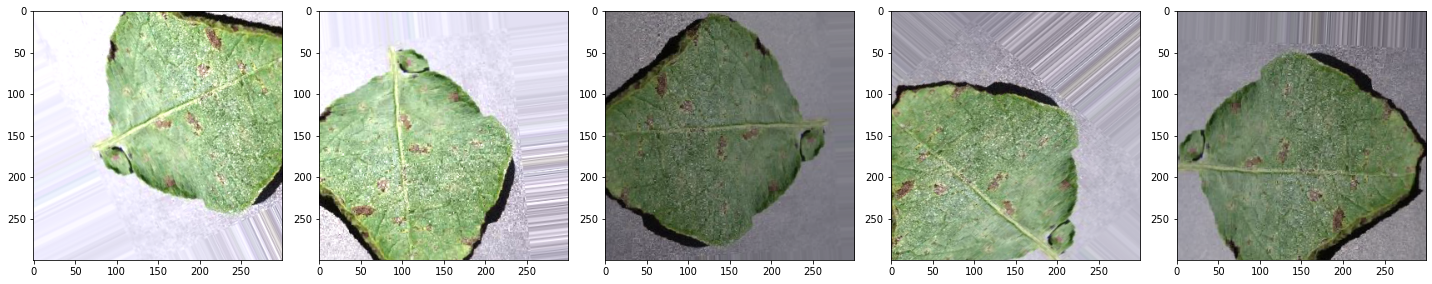

In [12]:
images = [leaves_train_generator[0][0][0] for i in range(5)]
plotImages(images)

In [9]:
leaves_val_generator.next()[0].shape,leaves_val_generator.next()[1].shape

((16, 300, 300, 3), (16, 3))

# **Model**

In [ ]:
vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras import layers
print('Adding new layers...')
output = vgg.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
predictions = Dense(3, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [ ]:
leaves_model = Model(inputs=vgg.input, outputs=predictions)

In [ ]:
for layer in leaves_model.layers[:-7]:
    layer.trainable = False
leaves_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [ ]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [ ]:
leaves_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [ ]:
trainable_count = np.sum([K.count_params(w) for w in leaves_model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in leaves_model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 58,243,907
Trainable params: 43,525,123
Non-trainable params: 14,718,784


# **Training Model**

In [ ]:
results = leaves_model.fit(leaves_train_generator,epochs=30,
                              steps_per_epoch=leaves_train_generator.n/batch_size,
                              validation_data=leaves_val_generator,
                             validation_steps=leaves_val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])

Epoch 1/30
75/75 [==============================] - 454s 6s/step - loss: 1.6548 - accuracy: 0.5833 - val_loss: 2.0632 - val_accuracy: 0.6667
Epoch 2/30
75/75 [==============================] - 34s 452ms/step - loss: 0.9161 - accuracy: 0.7234 - val_loss: 1.4469 - val_accuracy: 0.7604
Epoch 3/30
75/75 [==============================] - 34s 453ms/step - loss: 0.7130 - accuracy: 0.7801 - val_loss: 1.8934 - val_accuracy: 0.3125
Epoch 4/30
75/75 [==============================] - 34s 450ms/step - loss: 0.6948 - accuracy: 0.7851 - val_loss: 0.7317 - val_accuracy: 0.7812
Epoch 5/30
75/75 [==============================] - 34s 450ms/step - loss: 0.6086 - accuracy: 0.8365 - val_loss: 1.9174 - val_accuracy: 0.4896
Epoch 6/30
75/75 [==============================] - 34s 455ms/step - loss: 0.6512 - accuracy: 0.8353 - val_loss: 0.6699 - val_accuracy: 0.8229
Epoch 7/30
75/75 [==============================] - 34s 455ms/step - loss: 0.6287 - accuracy: 0.8233 - val_loss: 0.5977 - val_accuracy: 0.8646
E

# **Plot**

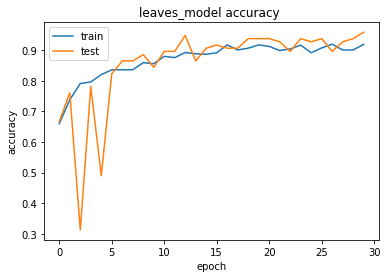

In [ ]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('leaves_model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

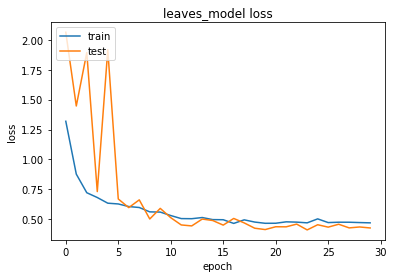

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('leaves_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Evalute and Performance model**

In [ ]:
leaves_model.evaluate(leaves_val_generator,steps=leaves_val_generator.n//batch_size)

6/6 [==============================] - 3s 421ms/step - loss: 0.4246 - accuracy: 0.9479


[0.42461538314819336, 0.9479166865348816]

In [ ]:
leaves_val_generator.reset()
leaves_model.evaluate(leaves_val_generator,steps=leaves_val_generator.n//batch_size)

6/6 [==============================] - 3s 413ms/step - loss: 0.4171 - accuracy: 0.9375


[0.41705334186553955, 0.9375]

In [ ]:
leaves_val_generator.reset()
y_pred=leaves_model.predict(leaves_val_generator,steps=leaves_val_generator.n/batch_size,verbose=1)

6/6 [==============================] - 3s 436ms/step


In [ ]:
leaves_val_generator.reset()
y_pred=leaves_model.predict(leaves_val_generator,steps=leaves_val_generator.n/batch_size,verbose=1)

6/6 [==============================] - 3s 442ms/step


In [ ]:
if val_suffle==True:
  per = np.random.permutation(leaves_val_generator.n)
  leaves_val_generator.index_array = per
  y_true = leaves_val_generator.classes[per]
else: 
  y_true = leaves_val_generator.classes

In [ ]:
y_pred=np.argmax(y_pred, axis=1)

In [ ]:
y_pred.shape,y_true.shape

((96,), (96,))

# **Precision,recall,f1-score,auccuracy score**

In [ ]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.9583333333333334
0.9112721417069244


In [ ]:
class_label=list(leaves_train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))

                       precision    recall  f1-score   support

Potato___Early_blight       0.96      1.00      0.98        45
 Potato___Late_blight       0.96      0.96      0.96        45
     Potato___healthy       1.00      0.67      0.80         6

             accuracy                           0.96        96
            macro avg       0.97      0.87      0.91        96
         weighted avg       0.96      0.96      0.96        96



In [ ]:
!pip install scikit-plot

# **Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Confusion matrix, without normalization


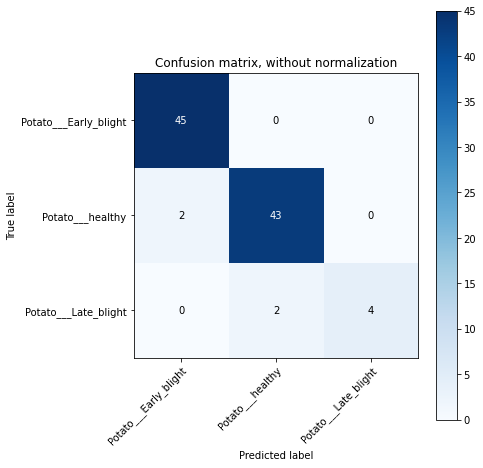

In [ ]:
#Plotting the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

#Defining the class labels
class_names=['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, title='Confusion matrix, without normalization')

Normalized confusion matrix


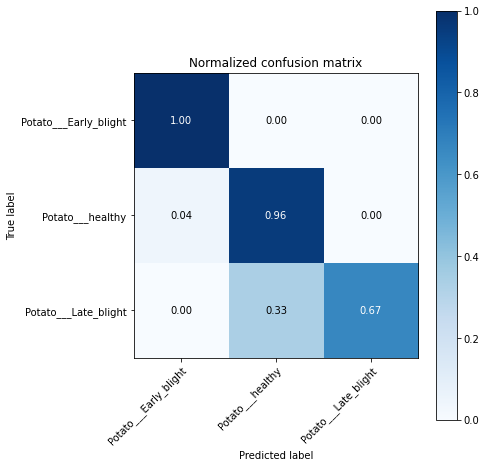

In [ ]:
#Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, normalize = True, title = 'Normalized confusion matrix')


# **ROC, AUC_Score ,ROC_AUC Curve for each class**

In [ ]:
y_prob=leaves_model.predict(leaves_val_generator,verbose=1)

6/6 [==============================] - 3s 441ms/step


In [ ]:
y_prob

array([[9.56e-01, 1.36e-02, 3.07e-02],
       [9.48e-01, 3.12e-02, 2.09e-02],
       [7.91e-01, 1.65e-01, 4.40e-02],
       [7.38e-01, 2.38e-01, 2.41e-02],
       [8.52e-01, 5.34e-02, 9.46e-02],
       [9.83e-01, 3.45e-03, 1.35e-02],
       [8.15e-01, 1.21e-01, 6.40e-02],
       [9.66e-01, 4.95e-03, 2.87e-02],
       [9.83e-01, 3.52e-03, 1.33e-02],
       [9.73e-01, 9.06e-03, 1.84e-02],
       [9.46e-01, 1.03e-02, 4.42e-02],
       [7.63e-01, 2.22e-01, 1.56e-02],
       [8.62e-01, 1.30e-01, 7.79e-03],
       [8.90e-01, 6.67e-02, 4.32e-02],
       [9.42e-01, 1.53e-02, 4.28e-02],
       [8.62e-01, 1.24e-01, 1.46e-02],
       [8.85e-01, 9.34e-02, 2.15e-02],
       [9.27e-01, 5.04e-02, 2.25e-02],
       [9.65e-01, 8.30e-03, 2.63e-02],
       [9.29e-01, 5.79e-02, 1.31e-02],
       [4.32e-01, 5.36e-01, 3.23e-02],
       [9.54e-01, 4.91e-03, 4.10e-02],
       [7.05e-01, 2.78e-01, 1.72e-02],
       [9.01e-01, 7.64e-02, 2.30e-02],
       [9.43e-01, 2.60e-02, 3.06e-02],
       [9.26e-01, 5.50e-0

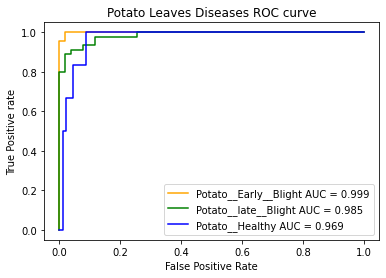

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
thresh ={}
roc_auc={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_true, y_prob[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
      
plt.plot(fpr[0], tpr[0], color='orange',label='Potato__Early__Blight AUC = %0.3f' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green',label='Potato__late__Blight AUC = %0.3f' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='blue',label='Potato__Healthy AUC = %0.3f' % roc_auc[2])

plt.title('Potato Leaves Diseases ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
auc_vgg16 = roc_auc_score(y_true, y_prob,multi_class="ovr",
                                     average="weighted")
print(auc_vgg16)

0.9904752178649239
